# 카메라 스티커앱 만들기
이번 노드에서는 OpenCV 라이브러리를 이용해 카메라 앱 만들어볼 것이다. 이를 통해 **동영상처리, 검출,키포인트 추청,추적, 카메라 원근**을 배울수 있다.
간단한 스티커부터 각도변화나 거리변화가 가능한 스티커까지 만들어보는것을 목표로 해보자

참고 : [gramman](https://opencv-python.readthedocs.io/en/latest/doc/01.imageStart/imageStart.html)

**스티커로 사용되는 파일 포맷**
png(Portable Network Graphics) 파일 
- 무손실 압축을 사용하기 때문에 이미지 손실이 없고 고품질 이미지를 생성하여 이미지 편집에 많이 사용되는 파일
-  배경이 투명해서 배경 이미지 위에 png 파일을 얹어 두 이미지를 자연스럽게 합성가능

---
**학습 목표**
- 얼굴인식 카메라의 흐름 이해
- dlib 라이브러리 사용
- 이미지 배열의 인덱싱 예외 처리
- 동영상 처리, 검출, 키포인트 추정, 추적, 카메라 원근의 기술을 익힌다.
- 간단한 스티커부터 시작해서 각도 변화가 가능하고 거리 변화에도 스티커를 적용할 수 있다. 


# 라이브러리

In [15]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib
from matplotlib.image import imread

스티커를 붙여볼 이미지를 불러오자

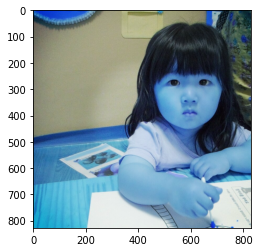

In [35]:
my_image_path = os.getenv('HOME')+'/aiffel/project/exp03_CameraStickerApp/data/2.png' 
img_bgr_original = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_bgr_copy = img_bgr_original.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr_copy)
plt.show()

사진이 잘 로딩되었지만 실제 사진과는 다르게 푸른빛이 많아 차갑게 나왔다. 이것은 opencv는 예외적으로 BGR(파랑, 녹색, 빨강)을 사용하기 때문인데, 원본 사진에서 붉은색은 푸른색으로, 푸른색은 붉은색으로 바뀌어 출력하는것이다. 따라서 CV이미지를 불러올때는 색보정 작업이 필요하다

참고로 matplotlib, dlib 등의 이미지 라이브러리는 모두 이미지 채널을 RGB(빨강, 녹색, 파랑) 순으로 사용한다. 

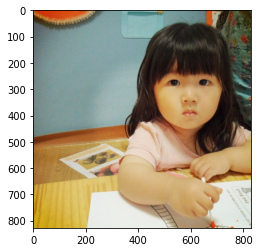

In [5]:
img_rgb = cv2.cvtColor(img_bgr_original, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

# 얼굴 검출(face detection)

dlib의 face detector : [참고](https://medium.com/@jongdae.lim/%EA%B8%B0%EA%B3%84-%ED%95%99%EC%8A%B5-machine-learning-%EC%9D%80-%EC%A6%90%EA%B2%81%EB%8B%A4-part-4-63ed781eee3c)
- Object detection 기술
- HOG(Histogram of Oriented Gradients)와 SVM(Support Vector Machine)을 사용해서 얼굴을 찾는다
 - HOG : 이미지에서 색상의 변화량, 이미지로부터 물체의 특징만 잘 잡아냄
 - SVM : 선형 분류기, 다차원 공간에서 이미지에 대한 벡터를 구분짓는 방법임. 색상만으로 벡터를 구분하기는 어렵고 HOG를 통해 만들어진 벡터에서 잘동작함. 



detector_hog를 이용해서 얼굴의 bounding box를 추출해보자
- 첫번째인자 : dlib은 rgb 이미지를 입력으로 받음
- 두번째인자 : 이미지 피라미드의 수, 
 작게 촬영된 얼굴을 크게 볼수 있게 해주어 정확한 검출이 가능
  - [참고](https://opencv-python.readthedocs.io/en/latest/doc/14.imagePyramid/imagePyramid.html)

In [6]:
detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

rectangles[[(489, 217) (712, 440)]]


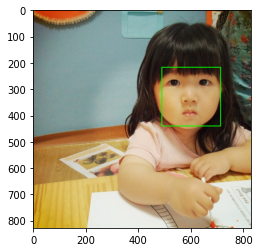

In [7]:
# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다
print(dlib_rects)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_bgr_copy, (l,t), (r,b), (0,255,0), 2 ,  lineType=cv2.LINE_AA)
    
img_rgb_rect = cv2.cvtColor(img_bgr_copy, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb_rect)

detector_hog 함수는 dlib.rectangles 타입의 객체를 반환하는데 내부 메소드로 left(), top(), right(), bottom(), height(), width()를 통해 검출한 박스에 대한 정보를 얻을 수있다 [link](http://dlib.net/python/index.html#dlib.rectangles)

# 얼굴 랜드마크(Face landmark localization)

face landmark localization : 스티커를 섬세하게 적용하기위해 얼굴의 주요위치(landmark)를 추론하하는 기술. face landmark는 detection 의 결과물인 bounding box 로 잘라낸(crop) 얼굴 이미지를 이용한다.

Object keypoint estimation 알고리즘 :  객체 내부의 점을 찾는 기술
1. top-down : bounding box를 찾고 box 내부의 keypoint를 예측

2. bottom-up : 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 box 생성


Dlib에 사용 되는 랜드마크 순서


- 랜드마크 점의 개수는 데이셋과 논문마다 다름
Dlib는 [ibug 300-W 데이터셋](https://ibug.doc.ic.ac.uk/resources/facial-point-annotations/)으로 학습한 pretrained model을 제공한다

- 참고 : [One Millisecond Face Alignment with an Ensemble of Regression T](https://www.cv-foundation.org/openaccess/content_cvpr_2014/papers/Kazemi_One_Millisecond_Face_2014_CVPR_paper.pdf)


<img src="https://ibug.doc.ic.ac.uk/media/uploads/images/annotpics/figure_68_markup.jpg" 
     style="float: left;  margin-right: 20px; margin-bottom: 20px; width:400px; height:300px;"  ></img>





Dlib의 weight file을 다운받아 bz2의 압축파일을 풀고 작업을 해보자
```
$ wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
$ mv shape_predictor_68_face_landmarks.dat.bz2 ~/aiffel/project/exp03_CameraStickerApp/models/
$ cd ~/aiffel/project/exp03_CameraStickerApp/models
$ bzip2 -d shape_predictor_68_face_landmarks.dat.bz2
```

In [8]:
model_path = os.getenv('HOME')+'/aiffel/project/exp03_CameraStickerApp/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환한다.

In [9]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 검출
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_bgr_copy, dlib_rect)
    list_points = list(map(lambda p:(p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0])) 

68


각각의 얼굴마다 68개의 랜드마크가 나왔다.
points 는 dlib.full_object_detection 의 객체로 parts() 함수로 개별 위치정보를 반환한다. 조금 더 직관적인 (x, y) 형태로 변환해 주고 list_points 에 리스트 형태로 저장했다.

랜드 마크를 이미지에 함께 출력해보자

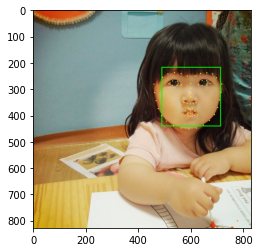

In [21]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_bgr_copy, point, 2, (0, 255, 255), -1)# (0,255,255) BGR중 Green, Red값만 지정 -> yellow

img_rgb_landmarks = cv2.cvtColor(img_bgr_copy, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb_landmarks)


# 스티커 적용하기
왕관스티커를 씌울 준비가 되었다. 랜드마크를 기준으로 눈썹위 얼굴 중앙(바비얼굴 작은 파란 점)에 스티커 적용하면 좋을 것 같다.

스티커를 어떤 위치에 놓을지는 얼굴의 위치, 카메라의 거리에따라 달라지므로 좌표를 일단 계산해보자.
![img](https://raw.githubusercontent.com/riverlike/Aiffel_Project/main/Exploration/Exp03/images/barbie.png)

좌표 계산전 OpenCV 좌표계에 대해서도 이해하면 좋을것 같다 :

x,y 좌표가 0,0인지점이다. top-left좌표  [참고](https://webnautes.tistory.com/580)

좌표 이미지상단의 좌측이며 오른쪽으로 움직이면 x값이 증가하고, 아래로 내려가면 y값이 증가한다

1. 스티커 위치 : 파란점의 상단에 붙이기
 - x = x(nose)
 - y = y(nose) - height/2
2. 스티커 크기 : 얼굴 검출한 너비와 높이와 동일하게 설정
 - width = height = width(bbox)


In [19]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print( 'nose pos:', landmark[30]) #30 : 코의 인덱스
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y)) #코의 위에 스티커를 놓을 위치
    print ('(w,h) : (%d,%d)'%(w,h)) #얼굴 검출 박스 너비와 높이
    

nose pos: (598, 330)
(x,y) : (598,218)
(w,h) : (224,224)


코의 중심, 즉 랜드마크 30번의 위치가 (598, 330)으로 나온다. 검출한 박스의 높이, 너비는 224이다. 따라서 바비인형의 파란점위치 (x,y)는 계산식에 의하면 (598,218)이 된다. 그럼 준비한 이미지 스티커를 읽어 얼굴 검출 사이즈에 맞게 리사이즈 해주고 스티커를 사진 이미지에 적용해주자

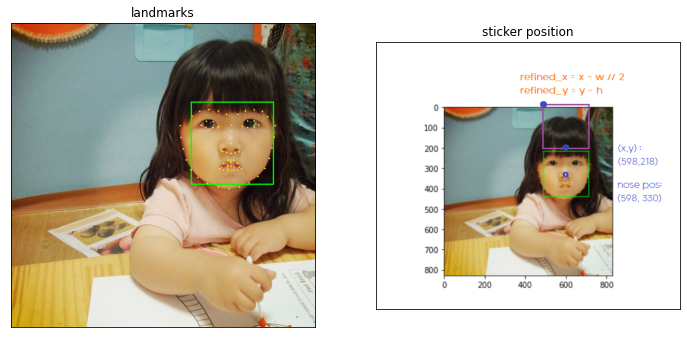

In [22]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_bgr_copy, point, 2, (0, 255, 255), -1)# (0,255,255) BGR중 Green, Red값만 지정 -> yellow

img_rgb_landmarks = cv2.cvtColor(img_bgr_copy, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,16))    
plt.subplot(1,2, 1)
plt.title('landmarks')
plt.xticks([])  # x = None 
plt.yticks([])  # y = None
plt.imshow(img_rgb_landmarks)
my_image_path = os.getenv('HOME')+'/aiffel/project/exp03_CameraStickerApp/data/2_position.png' 
img_position = imread(my_image_path) 

plt.subplot(1,2, 2)
plt.title('sticker position')
plt.xticks([])  # x = None 
plt.yticks([])  # y = None
plt.imshow(img_position)


In [23]:
sticker_path = os.getenv('HOME')+'/aiffel/project/exp03_CameraStickerApp/images/king.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))

print (img_sticker.shape)

(224, 224, 3)


**음수 좌표에 유의 하기**

opencv 데이터는 numpy ndarray 형태의 데이터를 사용하는데, ndarray는 음수 인덱스에 접근할 수 없기 때문에 음수에 대한 예외 처리에 유의해야한다.

원본이미지에 올리기위해 스티커의 좌표를 조정해주자. 바비인형의 파란화살표 위치로 보정해야한다. 사진에 따라 얼굴이 외곽에 맞닿아 있는 경우 스티커의 좌표가 사진 외곽으로 나와 음수좌표가 나오기도 한다. 


바비얼굴 사진의 경우도 보라색 박스 외곽으로 나가있는데 이럴때는 이미지 밖에 포함되는 범위를 제거하고 스티커를 붙여야하는 작업이 필요하다. 

In [13]:
refined_x = x - w // 2
refined_y = y - h
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (486,-6)


스티커가 원본 이미지 범위를 넘어가는 경우는 스티커의 시작점을 처리하는 방법은 아래와 같다. -y 크기만큼 스티커를 crop 하고, top 의 x좌표와 y 좌표를 각각의 경우에 맞춰 원본 이미지의 경계 값으로 수정하는 코드를 보자

In [25]:
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(refined_x,refined_y) : (%d,%d)'%(refined_x, refined_y))

(refined_x,refined_y) : (486,0)


이미지 밖으로 나갔던 y의 값이 y의 시작위치인 0으로 설정되었다.
실제 이미지 img_sticker의 픽셀값은 밖의 이미지부터가 아닌 y값이 6인지점부터 읽어드려서 재설정되었다. 즉 설명사진의 보라색 바깥부분을 제외한 부분만 sticker_area 가 될것이다.

이제 위치를 조정한 스티커를 적용해보자

In [30]:
# 길어서 복잡해 보이지만 img_show[from:to] 형식입니다
sticker_area = img_bgr_copy[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]


얼굴사진 이미지에서 스티커 영역만 읽어온다. 여기에 스티커 이미지 픽셀을 올릴걸이다.

In [31]:
img_bgr_copy[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0, sticker_area, img_sticker).astype(np.uint8)


### np.where
np.where 은 조건을 만족하는 인덱스를 찾아주는 함수로 여기에서는 img_sticker의 값이 있다면 0값이 아닐것이므로 왕관필셀이 있다고 볼수있다. 따라서 그부분은 img_sticker 적용하고 아닌부분은 sticker_area를 그대로 적용하면 되겠다

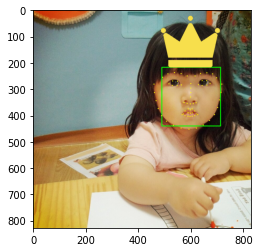

In [32]:
plt.imshow(cv2.cvtColor(img_bgr_copy, cv2.COLOR_BGR2RGB))

꼼꼼히 인덱스를 계산하다보니 머리가 아파지지만 이제 끝이 보인다.
bounding box와 landmark를 제거하고 최종 결과만 출력해보자
얼굴검출 박스와 랜드마크가 들어간 img_bgr_copy 이미지가 아닌 원복 파일에 왕관을 올리는 코드를 적용하면된다.

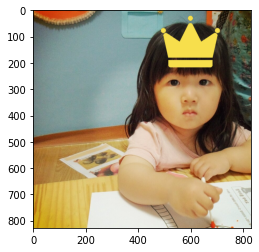

In [33]:
sticker_area = img_bgr_original[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr_original[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr_original, cv2.COLOR_BGR2RGB))
plt.show()

---
# Reference

- 얼굴 인식(Face Recognition) : [link](https://medium.com/@jongdae.lim/%EA%B8%B0%EA%B3%84-%ED%95%99%EC%8A%B5-machine-learning-%EC%9D%80-%EC%A6%90%EA%B2%81%EB%8B%A4-part-4-63ed781eee3c)

- cv 함수 : [link](https://dk-kang.tistory.com/entry/OpenCV-%EC%98%81%EC%83%81%EC%9D%B4%EB%AF%B8%EC%A7%80-%EB%8B%A4%EB%A3%A8%EA%B8%B06%EA%B7%B8%EB%A6%AC%EA%B8%B0-%ED%95%A8%EC%88%98)